# Week 6: Clustering and Association Mining

### What's on this week
1. [Preparing data for clustering](#prep)
2. [Building your first K-means clustering](#clustering)
3. [Understanding and visualising your clustering model](#viz)
4. [Implementing your own Apriori algorithm](#apriori)
5. [Running and understanding results of association mining](#assoc)
6. [Extending association mining to sequence mining](#sequence)

---

The practical note for this week introduces you to clustering and association rules mining using Python. In addition to the usual data preprocessing, model building and result evaluation/visualisation, I will also introduce you to implementing your own algorithm instead of only just using sklearn's.

**This tutorial notes is in experimental version. Please give us feedbacks and suggestions on how to make it better. Ask your tutor for any question and clarification.**

## 1. Preparing data for clustering<a name="prep"></a>

For our clustering this week, we will be using the `Census2000` dataset. This dataset contains the postal code-level summary of the 2000 United States Census. It has 7 variables:
* `ID`: Postal code of the region
* `LOCX`: Region longitude
* `LOCY`: Region latitude
* `MEANHHSZ`: Average household size in the region
* `MEDHHINC`: Median household income in the region
* `REGDENS`: Region population density percentile (1=lowest density, 100 = highest density)
* `REGPOP`: Number of people in the region

As usual, load up the data into pandas.

In [1]:
import pandas as pd
df = pd.read_csv('census2000.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 7 columns):
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     32165 non-null float64
RegPop      33178 non-null int64
MedHHInc    33178 non-null int64
MeanHHSz    33178 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.8+ MB


Just like week 2, we need to visualise the data to see whether there is data problems within it. We can use `seaborn` and `matplotlib` for that purpose.

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


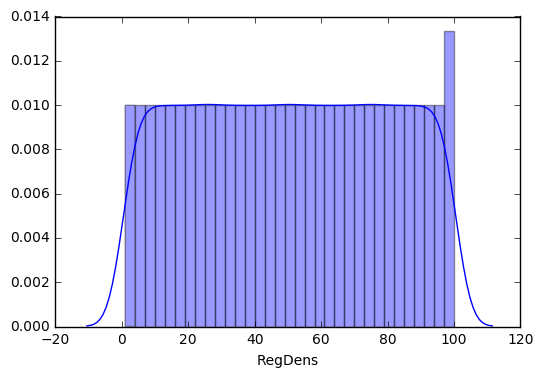

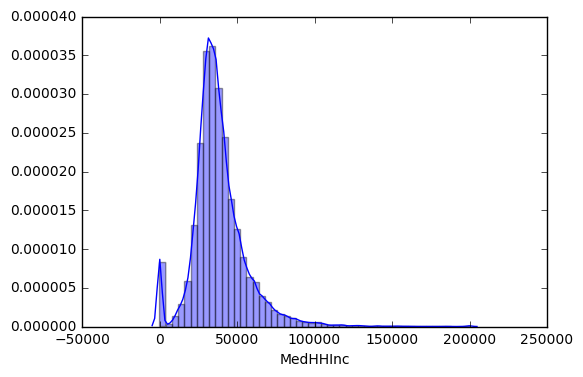

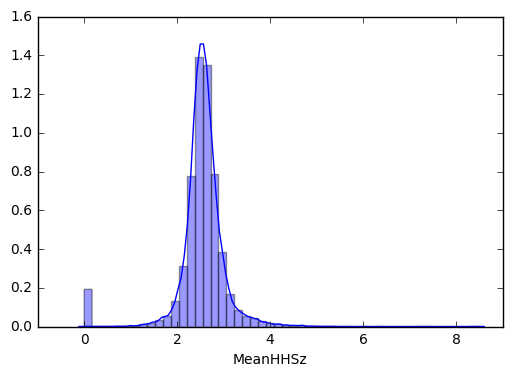

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

There seems to be some anomalies in `MeanHHSz` data. Let's zoom in closer.

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


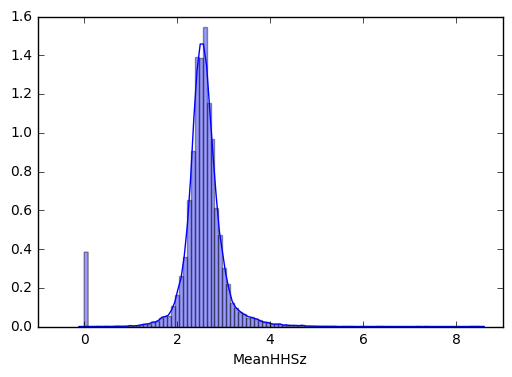

In [3]:
# Distribution of MeanHHSz, with increased number of bins. More bins = more specific distplot.
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna(), bins=100)
plt.show()

It becomes apparent that many of the records are valued at zero, and it seems very unlikely for an household to have zero members. This points out to a data problem. I wonder how does these errorneous values affect other variables. We could explore this relation using FaceTGrid.

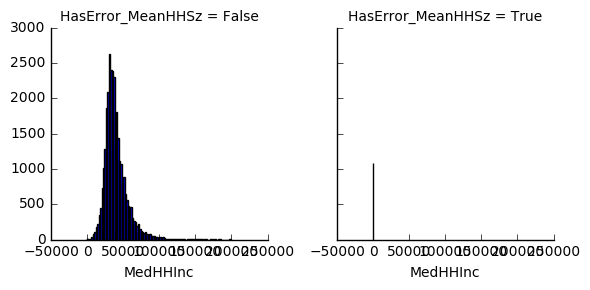

In [4]:
import numpy as np
df['HasError_MeanHHSz'] = df['MeanHHSz'] < 0.1

g = sns.FacetGrid(df, col='HasError_MeanHHSz')
g = g.map(plt.hist, 'MedHHInc', bins=100)

plt.show()

FacetGrid shows that errorneous data in `MeanHHSz` are correlated with errorneous data in other features. We can see that in `MedHHInc` here, most records with `MeanHHSz` also has way lower than normal values. This serves as a good reason to eliminate all rows with errorneous `MeanHHSz`.

In [5]:
# before
print("Before dropping errorneous rows", len(df))

# a very easy way to drop rows with MeanHHSz values below 0.1
df = df[df['MeanHHSz'] >= 0.1]

# after
print("After dropping errorneous rows", len(df))

Before dropping errorneous rows 33178
After dropping errorneous rows 32097


## 2. Building your first K-means clustering<a name="clustering"></a>

Now we are set to build our clustering model. Just before we jump in the models, let's determine the objective of this clustering process first. There are a number of good grouping objectives that we can apply in this dataset. We could cluster them based on location (`LocX` and `LocY`), demographic characteristics or both. For this tutorial, I would like to focus on demographic characteristics.

Thus, we will use `MedHHInc`, `MeanHHSz` and `RegDens` and drop the rest of the features. You might wonder why `RegPop` is discarded. First, it is a data about number of people in an area, which is already covered by `RegDens`. Secondly, `RegPop` is highly influenced by the actual size of the region, an information we do not have. In comparing regions using their demographic information, it is more accurate to use `RegDens`.

In [6]:
from sklearn.preprocessing import StandardScaler
df2 = df[['MedHHInc', 'MeanHHSz', 'RegDens']]
scaler = StandardScaler()

X = df2.as_matrix()
X = scaler.fit_transform(X)

Import our K-Means clustering from sklearn. Build a K-means cluster with K=3 and print out its `inertia` (sum of distances of samples to their closest cluster center/centroid). Remember, in clustering, we want to minimize the intra-cluster distance while maximizing the inter-cluster distances.

In [7]:
from sklearn.cluster import KMeans

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 52550.0791388
Centroid locations:
[ 1.33116729  0.90845614  0.75949011]
[-0.41332545 -0.08404607 -0.88723358]
[-0.17671528 -0.4041175   0.83180754]


In [8]:
# cluster_costs = []

# for k in range(2, 23, 2):
#     model = KMeans(n_clusters=k, random_state=42)
#     model.fit(X)
    
#     cluster_costs.append(model.inertia_)

# plt.scatter(range(2,23, 2), cluster_costs)
# plt.show()

## 3. Understanding and Visualising Your Clustering Model

We will dive deeper into our clustering model. A great way to start understanding our clustering results is to visualise the value distribution in our dataset. We have done this in a very limited way by printing the values of centroids.

To gain an even better view on how the clusters are spread out in the dataset, we could use seaborn's pairplot. We will need cluster IDs assigned to each record first, then call the pairplot.

Cluster membership
1    15284
2    10656
0     6157
Name: Cluster_ID, dtype: int64


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


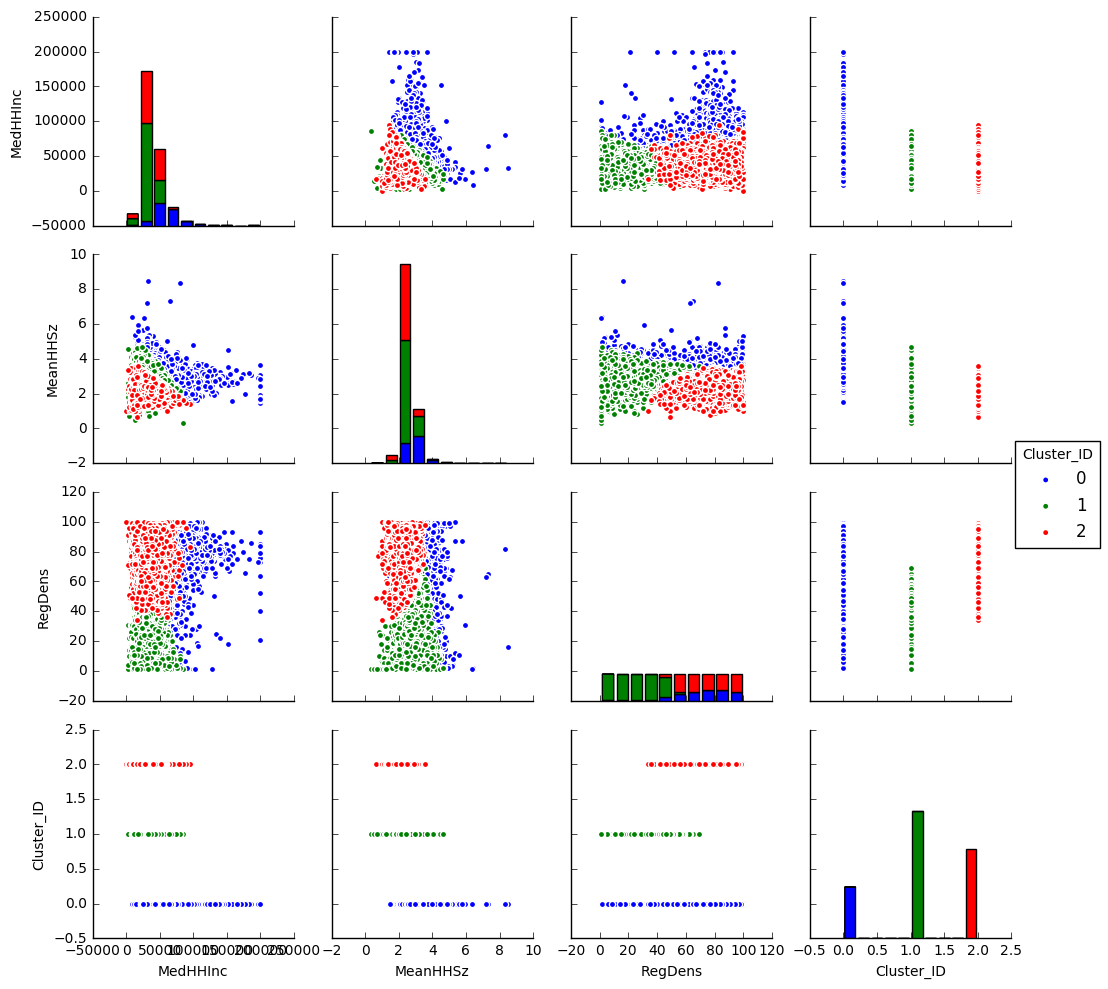

In [9]:
# assign cluster ID to each record in X. Ignore the warning, does not apply to our case here
y = model.predict(X)
df2['Cluster_ID'] = y

print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

The pairplot shows us how different cluster members have different value distribution on different variables. Here is how to read it:
1. Take `MeanHHSz` distribution for example (second row, fourth column). Cluster 1 generally covers regions with average large households, while cluster 0 and 2 covers the smaller ones.
2. Look at `MeanHHSz` and `RegDens` plot (second row, third column) and we could see the difference between regions in cluster 0 and 2. Cluster 0 covers less densely populated regions with smaller households, while cluster 2 covers more crowded regions and still small families.
3. For `MedHHInc` (first row, second column), pairplot shows that cluster 1 covering regions with higher median household.

Thus, we could profile the clusters as follow:
* Cluster 0: Sparse populated regions with smaller, low earning households.
* Cluster 1: Regions with large households and higher earnings.
* Cluster 2: Dense populated regions with smaller, low earning households.

While this visualisation is useful and you could derive the cluster profiles, it gets a bit confusing once you have more clusters. Take the following clustering model with `k` = 8.

In [10]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27888.205622
Centroid locations:
[-0.57526546 -0.70421756 -1.19374227]
[ 3.41626444  0.55361654  0.97391772]
[-0.27240607 -0.15316561 -0.00471647]
[-0.24602516  0.49726756 -0.94397156]
[ 1.11350948  0.31196674  0.77072106]
[-0.31508082  3.22414759  0.14641992]
[-0.43449711  0.68309031  1.13675126]
[-0.19819737 -1.04912812  1.14570387]


Cluster membership
2    7370
0    6074
3    5296
4    4900
7    3983
6    2464
1    1030
5     980
Name: Cluster_ID, dtype: int64


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


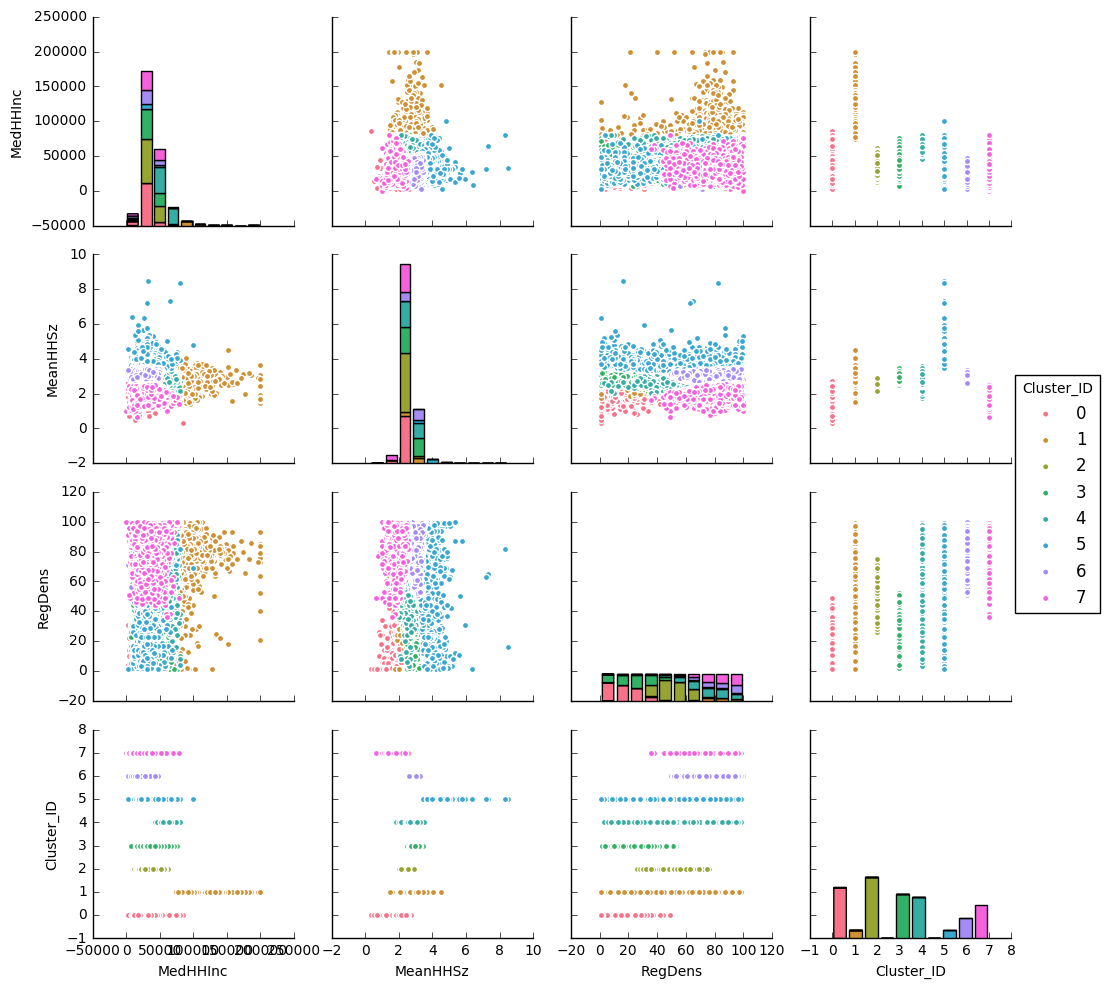

In [11]:
y = model.predict(X)
df2['Cluster_ID'] = y

print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

Thus, another way to profile our segments is to plot their respective variable distributions against the distribution from all data. We can do with distplot in the following code:

Distribution for cluster 0


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


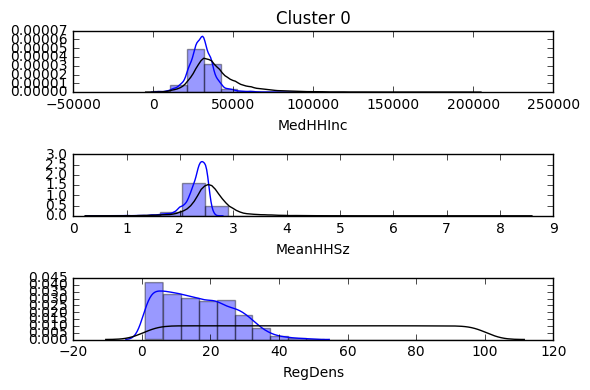

Distribution for cluster 1


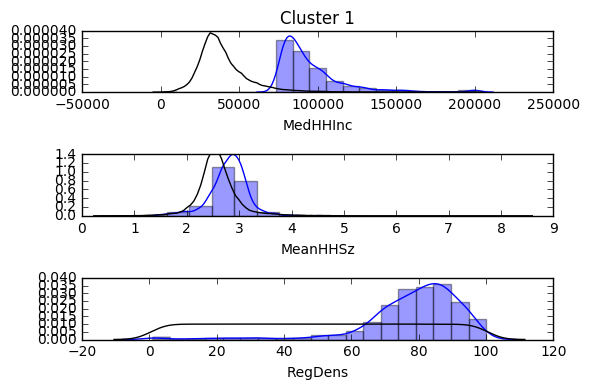

In [39]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['MedHHInc', 'MeanHHSz', 'RegDens']
n_bins = 20

# inspecting cluster 0
print("Distribution for cluster 0")
cluster_to_inspect = 0

# create subplots
fig, ax = plt.subplots(nrows=3)
ax[0].set_title("Cluster {}".format(cluster_to_inspect))

for j, col in enumerate(cols):
    # create the bins
    bins = np.linspace(min(df2[col]), max(df2[col]), 20)
    # plot distribution of the cluster using histogram
    sns.distplot(df2[df2['Cluster_ID'] == cluster_to_inspect][col], bins=bins, ax=ax[j], norm_hist=True)
    # plot the normal distribution with a black line
    sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

plt.tight_layout()
plt.show()

# inspecting cluster 1
print("Distribution for cluster 1")
cluster_to_inspect = 1

# again, subplots
fig, ax = plt.subplots(nrows=3)
ax[0].set_title("Cluster {}".format(cluster_to_inspect))

for j, col in enumerate(cols):
    # create the bins
    bins = np.linspace(min(df2[col]), max(df2[col]), 20)
    # plot distribution of the cluster using histogram
    sns.distplot(df2[df2['Cluster_ID'] == cluster_to_inspect][col], bins=bins, ax=ax[j], norm_hist=True)
    # plot the normal distribution with a black line
    sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")
    
plt.tight_layout()
plt.show()

Here, we plot the distributions of cluster 0 and cluster 1 against the normal distribution from all data. We could see the difference between these clusters as follow:
1. Cluster 0 covers regions with low median household income, small average household size and are less dense populated.
2. Cluster 1 covers regions with high median household income, large average household size and are very densely populated.

Association

Implementing our own apriori algorithm

In [12]:
Running it on our dataset

SyntaxError: invalid syntax (<ipython-input-12-07d6fa4d3d46>, line 1)